- [ ] Are missing values imputed/handled appropriately?
- [ ] Are distributions examined and described?
- [ ] Are outliers identified and addressed?
- [ ] Are appropriate summary statistics provided?
- [ ] Are steps taken during data cleaning and EDA framed appropriately?
- [ ] Does the student address whether or not they are likely to be able to answer their problem statement with         the provided data given what they've discovered during EDA?


__Part 3:__ Exploratory data analysis. The objective for this notebook is to explore the data and generate some insight from it.

__Imports__

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

Reading in the cleaned data

In [10]:
legal = pd.read_csv('./data/cleaned_legal.csv')
casual = pd.read_csv('./data/cleaned_casual.csv')
reddit= pd.read_csv('./data/cleaned_reddit.csv')
reddit.head()

,Unnamed: 0,index,author,created_utc,full_link,id,num_comments,retrieved_on,selftext,subreddit,title,url,posts,word_count
0,1,1,banksnosons,1629570605,https://www.reddit.com/r/legaladvice/comments/...,p8wn7t,3,1629577686,What can I do? My old neighbor witnessed the p...,1,"Package delivered to old residence, not being ...",https://www.reddit.com/r/legaladvice/comments/...,"package delivered to old residence, not being ...",70
1,2,2,Hangman_Matt,1629570478,https://www.reddit.com/r/legaladvice/comments/...,p8wlv0,12,1629577576,Does use of obscene language in school fall un...,1,First Ammendment rights and Schools,https://www.reddit.com/r/legaladvice/comments/...,first ammendment rights and schools.does use o...,216
2,3,3,Throwawaaaaaay526289,1629570313,https://www.reddit.com/r/legaladvice/comments/...,p8wk5r,4,1629577433,Basically what the title says. I've never been...,1,Virginia - If my employer only shows a set amo...,https://www.reddit.com/r/legaladvice/comments/...,virginia if my employer only shows a set amo...,206
3,4,4,unholychalice,1629570134,https://www.reddit.com/r/legaladvice/comments/...,p8wi9h,3,1629577281,Can I record with video and audio from my porc...,1,Can I record visual and audio from my front po...,https://www.reddit.com/r/legaladvice/comments/...,can i record visual and audio from my front po...,100
4,6,6,opsboop,1629569971,https://www.reddit.com/r/legaladvice/comments/...,p8wgjm,0,1629577141,"We live on a quiet, low traffic street with ma...",1,[Va] 7 year old walking up and down the street...,https://www.reddit.com/r/legaladvice/comments/...,[va] 7 year old walking up and down the street...,78


In [11]:
reddit.shape

(4642, 14)

In [12]:
reddit.drop('Unnamed: 0', axis=1, inplace = True)

### Correlations 

In [13]:
corr = reddit.corr()

In [14]:
corr['subreddit']  

index           0.034200
created_utc     0.764574
num_comments   -0.158912
retrieved_on    0.764763
subreddit       1.000000
word_count      0.208419
Name: subreddit, dtype: float64

<AxesSubplot:>

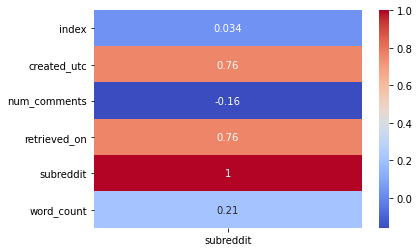

In [15]:
sns.heatmap(corr[['subreddit']], cmap='coolwarm', annot=True)

### Exploring post lengths and word counts

First let's look at the distribution of our data. '0' = Casual conversation subreddits and '1' = Legal advice subreddits. 

In [16]:
reddit.subreddit.value_counts()

1    2707
0    1935
Name: subreddit, dtype: int64

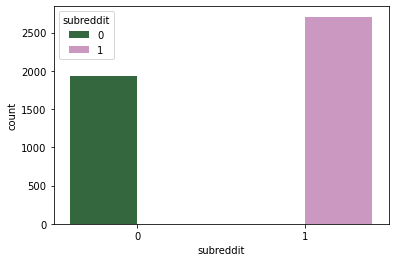

In [17]:
sns.countplot(x = reddit['subreddit'], hue = reddit['subreddit'], palette = 'cubehelix');

Using the 'word_count' column lets take a look at the distribution of posts lengths for each of the subrredit groups. 

/Users/aishakamara/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-18-aaf69b67131a>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


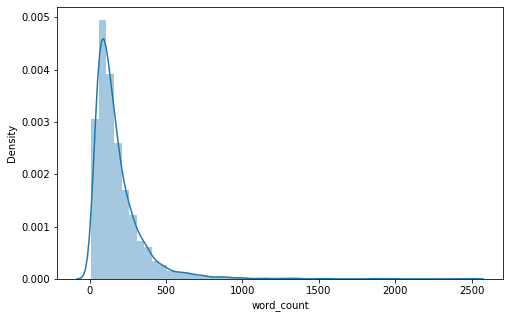

In [18]:
#Distribution of post lengths 
fig, ax = plt.subplots( figsize = (8,5))
sns.distplot(reddit['word_count'])
fig.show()

In [19]:
reddit.word_count.describe()

count    4642.000000
mean      180.574752
std       165.725196
min        11.000000
25%        79.000000
50%       133.000000
75%       224.000000
max      2482.000000
Name: word_count, dtype: float64

In [20]:
reddit.groupby ('subreddit').mean()[['word_count']]

,word_count
subreddit,
0,139.725581
1,209.774289


* When we look at the observations as a whole, the average posts length is 180 words with the shortest post being 11 words long and the longest post being 2482 words long.  
* When we look at post lengths based on subreddit type, the average length of posts in the casual conversation subreddit is 140 words and 210 for posts in the legal advice subreddits.

In [21]:
len(reddit.author.unique())

4244

Any Outliers? 

<AxesSubplot:xlabel='word_count'>

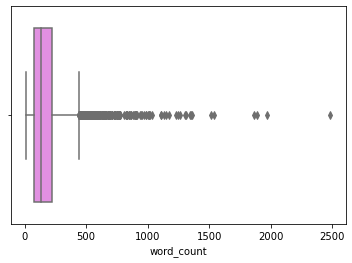

In [22]:
sns.boxplot(x=reddit['word_count'], color='violet')

From the boxplot displayed above there seems to be quite a number of outliers based on the corpus word count. 

### EDA on Common Words 

Now let's take a look at the most common words within each of the respective subreddits as well as combined subreddits,  using several methods and visual aids.


__Vectorize the text__
* In order to perform EDA on word count data, I'll need to first count-vectorize.

In [23]:
#Instantiate
cv = CountVectorizer(stop_words = 'english',
                    strip_accents='ascii',
                    lowercase= True,
                    max_features = 100,
                    min_df = 0.10,
                    max_df = 0.90,
                    binary=bool)
X= cv.fit_transform(reddit['posts'])

In [27]:
#count_vector.shape

We have 57 unique words based on the parameters set above. Out of these let's take a look at the 15 most common words. 

In [28]:
cv.get_feature_names()[:10]

['advice',
 'ago',
 'asked',
 'day',
 'days',
 'did',
 'didn',
 'does',
 'doing',
 'don']

Saving the list of common words into a dataframe. 

In [29]:
comm_words = pd.DataFrame(cv.transform(reddit.posts).todense(),
                  columns = cv.get_feature_names())

In [30]:
comm_words.head()

,advice,ago,asked,day,days,did,didn,does,doing,don,...,told,trying,ve,want,wanted,way,went,work,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [31]:
comm_words_list = comm_words.sum().sort_values(ascending = False).head(15)
comm_words_list

just      2184
like      1635
know      1407
time      1391
want      1087
got       1034
im         998
really     939
work       931
said       897
going      893
people     886
don        883
told       842
years      813
dtype: int64

Displaying the frequency of the most common words as a bar chart

In [32]:
# zipping actual words and sum of their countvectorizor for corpus
words = list(zip(cv.get_feature_names(), [x[0] for x in X.sum(axis=0).T.tolist()]))
# sorting
ranked = np.array(sorted(words, key=lambda x:x[1], reverse=True))

Text(0.5, 1.0, 'Fifteen of the most common words')

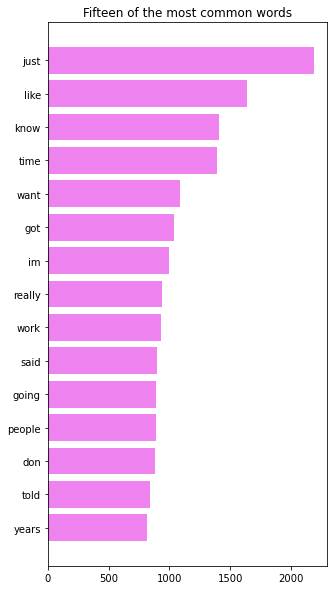

In [33]:
n = 15
plt.figure(figsize=(5, 10))
plt.barh(-np.arange(n),ranked[:n, 1].astype(float), height=.8, color ='violet')
plt.yticks(ticks=-np.arange(n), labels=ranked[:n, 0]);
plt.title('Fifteen of the most common words')

[Graphing Source Code](https://stackoverflow.com/questions/59340203/how-to-draw-bar-plot-of-30-most-common-words-found-in-fake-news-in-jupyter-noteb)

legal 

In [35]:
subreddit = reddit['subreddit']

In [36]:
legal_words = pd.concat([comm_words, reddit[subreddit]],axis =1)

KeyError: "None of [Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,\n            ...\n            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n           dtype='int64', length=4642)] are in the [columns]"

In [25]:
legal_words[legal_words['subreddit'] == 1].sort_values(ascending=False).head(15)

NameError: name 'legal_words' is not defined

From the common words identified above, I'd like to see them displayed in a word cloud. 

In [ ]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

In [ ]:
text= comm_words.posts.sort_values(ascending=False)[:100]
text_dict =comm_words.posts.sort_values(ascending=False).to_dict()

In [ ]:
cv.content_

In [ ]:
word_list = np.array(comm_words)

In [ ]:
wc = WordCloud(
    background_color= 'white',
    width=400, 
    height=400,
    max_words =100).generate_from_frequencies(comm_words)
plt.figure(figsize = (10,8))
plt.axis("off")
plt.imshow(wc, interpolation = 'bilinear')
plt.show()